# Import

In [72]:
import bz2
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import shutil

from torch.utils.data import Dataset, DataLoader

import nltk
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from collections import Counter
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader, random_split
import torchtext

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
import gc
import collections

import sys
sys.path.append('../')

import contractions 

import re
import gc
import pickle



#The essentials
STOPWORDS = set(stopwords.words("english"))
print('stopwords = ', STOPWORDS)

import bz2

stopwords =  {'were', 'in', "you'd", 's', 'their', 'shouldn', 'what', 'over', 'a', 'whom', 'my', 'herself', 'through', 'll', 'does', 'theirs', 'above', 'doesn', 'then', 'm', 'being', 'once', 'such', 'itself', 'didn', 'at', 'both', 'by', "mightn't", 'can', 'on', 'again', 'because', "aren't", 'doing', 'o', 'each', 'before', 'mustn', 'was', 'same', 'here', 'to', 'weren', 'isn', 'shan', 'nor', 'is', 'too', 'yours', "she's", 'why', 'further', 'as', 'if', 'no', "haven't", 'aren', "didn't", 'am', 'own', "shouldn't", "don't", 'but', 've', 'him', 'been', 'an', 'from', 'have', 'do', 'off', 'they', 'don', 'some', 'until', 'of', "that'll", 'after', "hasn't", "you'll", 'myself', 'only', 'between', 'with', 'more', 'i', 'his', 'or', 'how', 'its', 'won', 'any', 'most', 'having', 'our', 'below', 'during', 'yourselves', 'the', 't', 'all', "you've", 'out', "wasn't", "it's", 'about', 'this', 'where', 'other', 'hadn', 'there', 'your', 'himself', "you're", 'so', 'it', 'now', 'wouldn', 'who', 'up', "weren't"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the whole dataset and truncate it (for experiments)

In [44]:
root = os.getcwd()
datasetpath = os.path.join(root, 'dataset')
assert os.path.exists(datasetpath), f'dataset path does not exist {datasetpath}'

In [51]:
train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
train_lines = train_txt.readlines()
# test_txt = bz2.BZ2File(os.path.join(datasetpath, 'test.ft.txt.bz2'))

In [46]:
train_lines = train_txt.readlines()
del train_txt
gc.collect()

1555

In [47]:
for line in train_lines[:5]:
    print(line)

In [53]:
#only tkae 10% of this dataset
LIMIT = int(0.05 * len(train_lines))
print('limit = ', LIMIT)

truncated_train_lines = train_lines[:LIMIT]

TRAIN_RATIO = 0.8
train_len = int(len(truncated_train_lines) * TRAIN_RATIO)

train_array = [x.decode('utf-8') for x in truncated_train_lines[:train_len]]
val_array = [x.decode('utf-8') for x in truncated_train_lines[train_len:]]

#apply limit to a big dataset
train_array = train_array[:LIMIT]

print('train len = ', len(train_array))
print('val len = ', len(val_array))

limit =  180000
train len =  144000
val len =  36000


In [56]:
truncated_file_path = os.path.join(datasetpath, 'truncated_text.csv')
print(type(train_array))
X_array = []
y_array = []
for line in train_array:
    parts = line.split(' ')
    label = parts[0]
    feature = ' '.join(parts[1:])

    X_array.append(feature)
    y_array.append(label)

truncated_text_df = pd.DataFrame({'label':y_array, 'text':X_array})
truncated_text_df.head()

print(truncated_text_df.shape)
truncated_text_df.to_csv(truncated_file_path)

<class 'list'>


# Process the dataset

- for experiments, work on the truncated_train.ft.txt.bz2 file
- Clean the text here

In [5]:
root = os.getcwd()
datasetpath = os.path.join(root, 'dataset')
assert os.path.exists(datasetpath), f'dataset path does not exist {datasetpath}'
truncated_file_path = os.path.join(datasetpath, 'truncated_text.csv')

In [6]:
train_df = pd.read_csv(truncated_file_path, index_col=0)
train_df['length'] = train_df['text'].apply(lambda s: len(s))
print(train_df.shape)
train_df.head()
# X_array,y_array,train_df = load_from_csv(truncated_file_path)

(144000, 3)


,label,text,length
0,__label__2,Stuning even for the non-gamer: This sound tra...,427
1,__label__2,The best soundtrack ever to anything.: I'm rea...,510
2,__label__2,Amazing!: This soundtrack is my favorite music...,761
3,__label__2,Excellent Soundtrack: I truly like this soundt...,744
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",482


# A little EDA

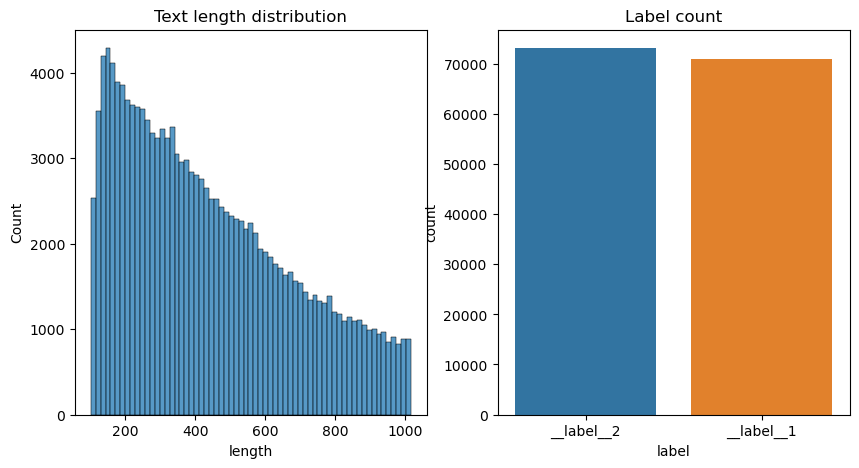

In [7]:
#plot 2, hist of length
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(train_df, x = 'length', ax = ax1)
ax1.set_title("Text length distribution")
sns.countplot(train_df, x = 'label', ax = ax2)
ax2.set_title("Label count")
plt.show()

# Build array

In [52]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com, 
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params: 
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text. 
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review  
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'test string special characters punctuations _'

In [54]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label.strip() == '__label__1' else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [55]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['label'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

100%|██████████| 144000/144000 [00:02<00:00, 67588.59it/s]


vocab len =  36166


100%|██████████| 144000/144000 [00:01<00:00, 93165.23it/s] 


In [56]:
print(len(set(train_y.tolist())))

2


In [59]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['stuning', 'even', 'non', 'gamer', 'sound', 'track', 'beautiful', 'paints', 'senery', 'mind', 'well', 'would', 'recomend', 'even', 'people', 'hate', 'vid', 'game', 'music', 'played', 'game', 'chrono', 'cross', 'games', 'ever', 'played', 'best', 'music', 'backs', 'away', 'crude', 'keyboarding', 'takes', 'fresher', 'step', 'grate', 'guitars', 'soulful', 'orchestras', 'would', 'impress', 'anyone', 'cares', 'listen', '_']
length=45
ids=tensor([    0,    15,   482,  8732,    91,   348,   240,  6270,     0,   290,
           13,     8,  1525,    15,    40,   492, 14605,   108,    41,   403,
          108, 26318,  1583,   661,    30,   403,    20,    41,  6820,   149,
         3670,     0,   310, 15953,   927,  7954,  3160,  3760, 17565,     8,
         4643,    94,  2140,   221,  7850,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

In [60]:
print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

ids shape =  torch.Size([144000, 173])
y shape =  torch.Size([144000])
lengths shape =  torch.Size([144000])


# Building dataset

In [61]:
class AmazonReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = AmazonReviewDataset(train_ids, train_y, train_lengths)

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  115200
train dataloader len =  450
val dataset len =  28800
val dataloader len =  113



# Building model

In [63]:

class LSTM(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.apply(self.initialize_weights)
    
    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if "bias" in name:
                    nn.init.zeros_(param)
                elif "weight" in name:
                    nn.init.orthogonal_(param)
                    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [64]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [78]:
def tune(model, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"The model has {model.count_parameters()} trainable parameters")



    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(10):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss 
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
    epochs = list(range(len(history['test_accs'])))
    sns.lineplot(y = history["train_accs"], label ='train accuracy', x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy', x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Baseline

In [75]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [79]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

output dim =  2
The model has 14460602 trainable parameters


training...:   1%|          | 3/450 [00:13<32:14,  4.33s/it][E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument
training...:   1%|          | 3/450 [00:17<44:27,  5.97s/it]


KeyboardInterrupt: 